# IS318 - Machine Learning
## TP2 - Linear classification

The goal of this TP is to experiment with linear models for classification.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_classification
from sklearn.model_selection import train_test_split

### 1. Dataset

We will work with a synthetic binary classification dataset:

(500, 2) (500,)


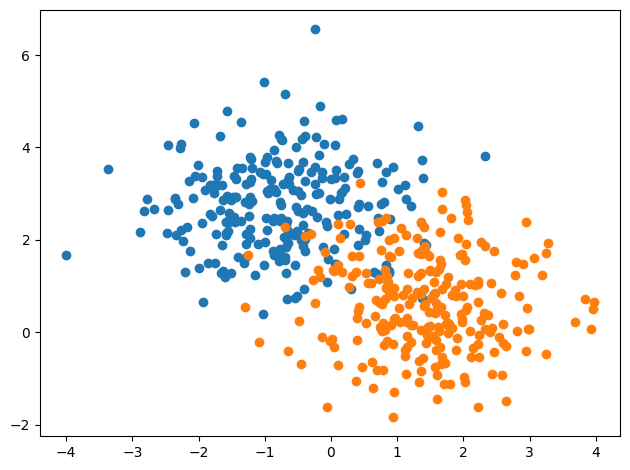

In [2]:
X, y = make_blobs(n_samples=500, n_features=2, centers=2, center_box=(-3, 3), random_state=42) # Easy
# X, y = make_classification(n_samples=500, n_features=2, n_redundant=0, n_informative=2) # Harder
plt.scatter(X[:, 0][y == 0], X[:, 1][y == 0])
plt.scatter(X[:, 0][y == 1], X[:, 1][y == 1])
plt.tight_layout()
print(X.shape, y.shape)

Before implementing a classification method, we will apply some preprocessing steps.

**(Question)** Preprocessing: normalize the data such that it has zero mean and unit variance. To do that, for each feature, substract the mean and divide by the standard deviation over the samples. Plot the data.

This procedure is called *standardization*.
It is useful for numerical stability (notably for gradient descent).

In [3]:
N = X.shape[0]
X1_mean = np.mean(X[:, 0])
X2_mean = np.mean(X[:, 1])
X1_deviation = np.sqrt(np.sum(np.power(X[:, 0]-X1_mean, 2))/N)
X2_deviation = np.sqrt(np.sum(np.power(X[:, 1]-X2_mean, 2))/N)
X[:, 0] = (X[:, 0]-X1_mean)*(1/X1_deviation) 
X[:, 1] = (X[:, 1]-X2_mean)*(1/X2_deviation)

In [4]:
assert np.allclose(X.mean(axis=0), 0.)
assert np.allclose(X.var(axis=0), 1.)

**(Question)** Plot the data points as above to observe the difference of standardization.

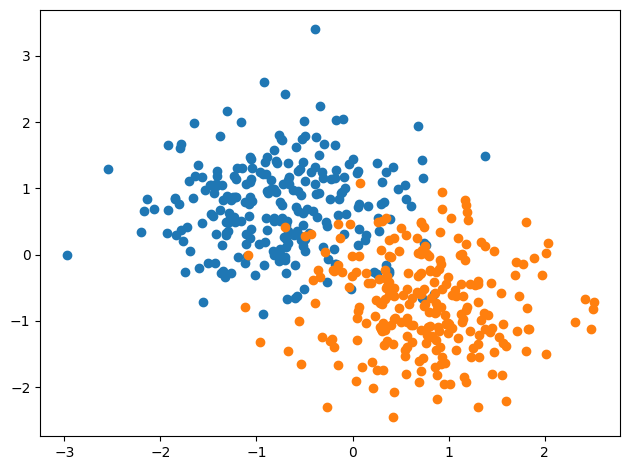

In [5]:
plt.scatter(X[:, 0][y == 0], X[:, 1][y == 0])
plt.scatter(X[:, 0][y == 1], X[:, 1][y == 1])
plt.tight_layout()

**(Question)** As usual, add a column with ones to simplify dot product notation. Then, split the dataset into training and validation sets.

In [6]:
#Adding the column of ones
col = np.ones((X.shape[0],1))
X_ones = np.hstack((col, X))
X = X_ones

# Splitting our dataset
rng = np.random.default_rng(42)
points_permutated = rng.permutation(N)
X_shuffle = X[points_permutated]
X_train = X_shuffle[:375]
X_valid = X_shuffle[375:]
y_shuffle = y[points_permutated]
y_train = y_shuffle[:375]
y_valid = y_shuffle[375:]

In [7]:
assert X.shape[1] == 3
assert np.all(X[:, 0] == 1.)

**(Question)** With real data, it is considered wrong to apply standardization before splitting the dataset. Can you explain why?

### 2. Logistic regression

**(Question)** Complete the `LogisticRegression` class below to implement logistic regression for binary classification.
- For the `fit` method, implement a simple gradient descent on the binary cross entropy loss. Record the evolution of the loss over the iterations in the `loss_hist` attribute.
- For the `predict` method, compute predictions from the model and return the binary decisions by thresholding at $0.5$.

In [8]:
class LogisticRegression():
    
    def __init__(self, learning_rate=0.1, n_iters=1000):
        self.learning_rate = learning_rate
        self.n_iters = n_iters
    
    def sigmoid(self, x):
        return 1/(1+np.exp(x))
        
    def binary_cross_entropy(self, y, y_pred):
        cost = 0
        for i in range(y.shape[0]):
            cost += -y[i]*np.log(y_pred[i]+1e-7) - (1-y[i])*np.log(1-y_pred[i]+1e-7)
        return cost/y.shape[0]
        
    def fit(self, X, y):
        #self.w = np.random.randn(X.shape[1])
        self.w = np.zeros(X.shape[1])
        self.loss_hist = []
        i = 0
        while i < self.n_iters:
            y_pred = self.sigmoid(X@self.w)
            self.w = self.w - (self.learning_rate/y_pred.shape[0])*((y-y_pred).T@X)
            self.loss_hist.append(self.binary_cross_entropy(y, y_pred))
            i = i + 1
            
    def predict(self, X):
        pred = self.sigmoid(X@self.w)
        for i in range(pred.shape[0]):
            if pred[i] >= 0.5 :
                pred[i] = 1
            else :
                pred[i] = 0
        return pred

**(Question)** Apply your logistic regression model with default arguments to our synthetic dataset. Report the classification accuracy on the training and validation sets.

In [11]:
model = LogisticRegression()
model.fit(X_train, y_train)
pred = model.predict(X_valid)
pred_training = model.predict(X_train)
acc = model.binary_cross_entropy(y_valid, pred)
acc_training = model.binary_cross_entropy(y_train, pred_training)
print(f"The classification accuracy on the training set is : {model.loss_hist[-1]: .4f} and on the validation set is {acc: .4f} ")

The classification accuracy on the training set is :  0.1769 and on the validation set is  0.7737 


**(Question)** Plot the decision boundary on top on the data points.

*Hint*: to compute the decision boundary, start from its equation and transform it to an usual affine formulation.

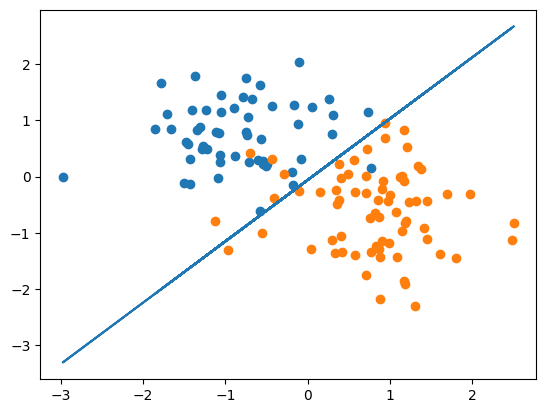

In [12]:
z = np.ones(np.shape(X_valid)[0])
for i in range(z.shape[0]):
    z[i] = - (model.w[1]/model.w[2])*X_valid[i][1] - (model.w[0]/model.w[2])
plt.plot(X_valid[:, 1],z)
plt.scatter(X_valid[:, 1][y_valid == 0], X_valid[:, 2][y_valid == 0])
plt.scatter(X_valid[:, 1][y_valid == 1], X_valid[:, 2][y_valid == 1])

**(Question)** Play around with the `learning_rate` and `n_iters` hyperparameters to see the impact on gradient descent convergence.
Plot the evolution of the loss over the iterations for different learning rates.

[ 180.          130.49758342 -138.02811175]


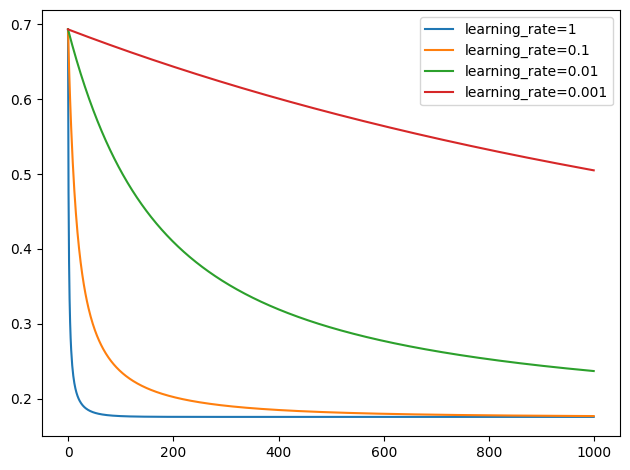

In [26]:
model1 = LogisticRegression(learning_rate=0.01)
model2 = LogisticRegression(learning_rate=0.001)
model3 = LogisticRegression(learning_rate=1)
model1.fit(X_train, y_train)
model2.fit(X_train, y_train)
model3.fit(X_train, y_train)
iterations = [i for i in range(len(model1.loss_hist))]
plt.plot(iterations, model3.loss_hist, label='learning_rate=1')
plt.plot(iterations, model.loss_hist, label='learning_rate=0.1')
plt.plot(iterations, model1.loss_hist, label='learning_rate=0.01')
plt.plot(iterations, model2.loss_hist, label='learning_rate=0.001')
plt.legend()
plt.tight_layout()

### 3. Gaussian generative model

**(Question)** Complete the `GaussianGenerativeModel` class below.

In [ ]:
class GaussianGenerativeModel():

    def fit(self, X, y):
        N = y.shape[0]
        frequency_1 = np.sum(y)/N
        mu_1 = (1/frequency_1)*np.sum(y.T@X)
        mu_0 = (1/(N-frequency_1)*np.sum((np.ones_like(y.T)-y.T)@X)
        sigma = (1/N)*np.sum(X-)
        
    def predict(self, X):
        

**(Question)** Apply your gaussian generative model to our synthetic dataset. Report the classification accuracy on the training and validation sets.

*Hint:* The column with ones is not needed for this model.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

**(Question)** Plot the decision boundary on top on the data points and compare it with the one obtained with logistic regression.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()

### 4. Comparison with `sklearn`

**(Question)** Apply logistic regression using the `LogisticRegression` class from the `scikit-learn` library. Compare the results with your previous implementation.

*Hints:*
- If your features are already augmented with a column of ones, set the `fit_intercept` parameter to `False`
- Set `penalty` (regularization to `'none'` to match your unregularized implementation

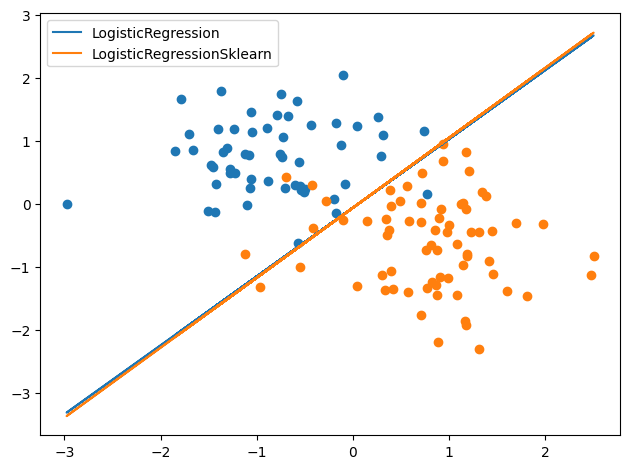

In [45]:
from sklearn.linear_model import LogisticRegression as LogisticRegressionSklearn

clf = LogisticRegressionSklearn(penalty='none', fit_intercept=False).fit(X_train, y_train)
clf.predict(X_valid)

b, w1_sk, w2_sk = clf.coef_.T
c = - b/w2_sk
m = - w1_sk/w2_sk

z_sk = np.ones(np.shape(X_valid)[0])
for i in range(z.shape[0]):
    z_sk[i] =  m*X_valid[i][1] + c


plt.plot(X_valid[:, 1],z, label='LogisticRegression')
plt.plot(X_valid[:, 1],z_sk, label='LogisticRegressionSklearn')
plt.scatter(X_valid[:, 1][y_valid == 0], X_valid[:, 2][y_valid == 0])
plt.scatter(X_valid[:, 1][y_valid == 1], X_valid[:, 2][y_valid == 1])
plt.legend()
plt.tight_layout()

### 5. Application to breast cancer dataset

In [56]:
from sklearn.datasets import load_breast_cancer
dataset = load_breast_cancer()

**(Question)** Load the data into `X` and `y` variables. Familiarize yourself with this dataset. What are the dimensions? Explain what they mean.

In [64]:
X, y = load_breast_cancer(return_X_y=True)
print(X.shape)
print(y.shape)

(569, 30)
(569,)


X is a (569, 30) matrix each line is a sample and each column is a feature for example we have mean radius or mean perimeter of Tumor and y is a vector of prediction either malignant tumor or benign tumor.

**(Question)** Split into train/test and preprocess the data.

In [62]:
rng = np.random.default_rng(42)
points_permutated = rng.permutation(X.shape[0])
X_shuffle = X[points_permutated]
X_train = X_shuffle[:426]
X_valid = X_shuffle[426:]
y_shuffle = y[points_permutated]
y_train = y_shuffle[:426]
y_valid = y_shuffle[426:]

**(Question)** Apply your implementations of logistic regression and gaussian generative model to this dataset.

In [66]:
# Add column of ones for our model
col = np.ones((X.shape[0],1))
X_ones = np.hstack((col, X))
X = X_ones

model = LogisticRegression()
model.fit(X_train, y_train)
pred = model.predict(X_valid)


/tmp/ipykernel_8860/1227738026.py:8: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(x))


**(Question)** Apply cross-validation (see `sklearn.model_selection`) on your implementations to successively train several models and obtain predictions for the whole dataset.

In [ ]:
# YOUR CODE HERE
raise NotImplementedError()